In [1]:
import pandas as pd
import datetime
import csv
import re
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
from tensorflow.keras import models, layers, callbacks, preprocessing as kprocessing
import sys, traceback
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from datetime import datetime
import matplotlib.pylab as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Create BiLSTM model
def create_model_bilstm(units, X_train):
    model = models.Sequential()
    model.add(layers.Bidirectional(layers.LSTM(units = units,                             
              return_sequences=True),
              input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Bidirectional(layers.LSTM(units = units)))
    model.add(layers.Dense(1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model
# Create GRU model
def create_model_GRU(units,  X_train):
    model = models.Sequential()
    model.add(layers.GRU(units = units, activation='tanh', return_sequences = True,
                input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(layers.Dropout(0.2))
    #model.add(layers.GRU(units = units, return_sequences = True))
    #model.add(layers.Dropout(0.2))
    model.add(layers.GRU(units = units))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(units = 1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model

# Create LSTM  model
def create_model_LSTM(units,  X_train):
    model = models.Sequential()
    model.add(layers.LSTM(units = units,  activation='tanh', return_sequences = True,
                input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(layers.Dropout(0.2))
    model.add(layers.LSTM(units = units))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(units = 1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model

In [3]:
# Fit BiLSTM, LSTM and GRU
def fit_model(model, X_train, y_train):
    early_stop = callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2, batch_size = 32, 
                        shuffle = False, callbacks = [early_stop], verbose=0)
    return history

In [4]:
# Create a 3D input
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

In [5]:
# Plot train loss and validation loss
def plot_loss (history):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

In [6]:
# Make prediction
def prediction(model, X_test, scaler_y, isLSTM=False, isGRU=False):
    prediction = model.predict(X_test)
    if (isLSTM):
        #print(prediction.shape)
        #print(prediction)
        #prediction = scaler_y.inverse_transform(prediction[:, 0])
        prediction = scaler_y.inverse_transform(prediction)
    elif (isGRU):
        #print(prediction.shape)
        #print(prediction)
        #prediction = scaler_y.inverse_transform(prediction[:, 0])
        prediction = scaler_y.inverse_transform(prediction)
    else:
        #print(prediction.shape)
        #print(prediction)
        prediction = scaler_y.inverse_transform(prediction)
    return prediction

In [7]:
# Plot true future vs prediction
def plot_future(prediction, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='True Future')     
    plt.plot(np.arange(range_future),np.array(prediction),
            label='Prediction')
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Daily water consumption ($m^3$/capita.day)')

In [8]:
# Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ': mae: {:.4f} rmse: {:.4f}'.format(mae,rmse))
    #print('Mean Absolute Error: {:.4f}'.format(mae))
    #print('Root Mean Square Error: {:.4f}'.format(rmse))
    #print('')

In [9]:
def create_data(filename, scaler_x, scaler_y):
    df = pd.read_csv(filename)

    # Split train data and test data
    train_size = int(len(df)*0.8)
    train_dataset, test_dataset = df.iloc[:train_size],df.iloc[train_size:]

    #print('Dimension of train data: ',train_dataset.shape)
    #print('Dimension of test data: ', test_dataset.shape)
    X_train = train_dataset.iloc[: , :-1]
    X_test = test_dataset.iloc[: , :-1]
    y_train = train_dataset.iloc[:,-1:]
    y_test = test_dataset.iloc[:,-1:]
    #print('Dimension of train X: ',X_train.shape)
    #print('Dimension of test X: ', X_test.shape)
    # Different scaler for input and output
    # Fit the scaler using available training data
    input_scaler = scaler_x.fit(X_train)
    output_scaler = scaler_y.fit(y_train)
    # Apply the scaler to training data
    train_y_norm = output_scaler.transform(y_train)
    train_x_norm = input_scaler.transform(X_train)
    # Apply the scaler to test data
    test_y_norm = output_scaler.transform(y_test)
    test_x_norm = input_scaler.transform(X_test)
    return train_x_norm, train_y_norm, test_x_norm, test_y_norm


In [12]:
def create_data_n225(filename, scaler_x, scaler_y):
    df = pd.read_csv(filename)

    # Split train data and test data
    train_size = int(len(df)*0.8)
    train_dataset, test_dataset = df.iloc[245:],df.iloc[:245]

    #print('Dimension of train data: ',train_dataset.shape)
    #print('Dimension of test data: ', test_dataset.shape)
    X_train = train_dataset.iloc[: , :-1]
    X_test = test_dataset.iloc[: , :-1]
    #print(X_test.tail(10))
    y_train = train_dataset.iloc[:,-1:]
    y_test = test_dataset.iloc[:,-1:]
    #print('Dimension of train X: ',X_train.shape)
    #print('Dimension of test X: ', X_test.shape)
    # Different scaler for input and output
    # Fit the scaler using available training data
    input_scaler = scaler_x.fit(X_train)
    output_scaler = scaler_y.fit(y_train)
    # Apply the scaler to training data
    train_y_norm = output_scaler.transform(y_train)
    train_x_norm = input_scaler.transform(X_train)
    # Apply the scaler to test data
    test_y_norm = output_scaler.transform(y_test)
    test_x_norm = input_scaler.transform(X_test)
    return train_x_norm, train_y_norm, test_x_norm, test_y_norm

In [13]:
scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))
#filename="data/taeix_lstm_input.csv"
#filename="data/taiex_ready_99_03.csv"
#filename="data/taiex_ready_99_04.csv"
#filename="data/covid_fts.csv"

#filename="data/taiex_ready_2000.csv"
#filelist=["data/taiex_ready_99_04.csv","data/taiex_ready_99_03.csv"]
#filelist=["data/N225_fts.csv","data/covid_fts.csv"]
#filelist = ["data/taiex_ready_2000.csv", "data/taiex_ready_2001.csv","data/taiex_ready_2002.csv","data/taiex_ready_2003.csv","data/taiex_ready_2004.csv"]
#filelist = ["data/taiex_2000_H_50.csv", "data/taiex_2001_H_50.csv","data/taiex_2002_H_50.csv","data/taiex_2003_H_50.csv","data/taiex_2004_H_50.csv"]
#filelist = ["data/taiex_2000_F_50.csv", "data/taiex_2001_F_50.csv","data/taiex_2002_F_50.csv","data/taiex_2003_F_50.csv","data/taiex_2004_F_50.csv"]
#filelist = ["data/Enrollments_G_5.csv", "data/Enrollments_F_5.csv", "data/Enrollments_H_5.csv"
#            ,"data/Enrollments_G_7.csv", "data/Enrollments_F_7.csv", "data/Enrollments_H_7.csv"
#           ,"data/Enrollments_G_10.csv", "data/Enrollments_F_10.csv", "data/Enrollments_H_10.csv"]
#filelist = ["data/Enrollments_G_10.csv", "data/Enrollments_F_10.csv", "data/Enrollments_H_10.csv"]
filelist = ["data/N225_G_5.csv", "data/N225_F_5.csv", "data/N225_H_5.csv",
           "data/N225_G_9.csv", "data/N225_F_9.csv", "data/N225_H_9.csv",
           "data/N225_G_10.csv", "data/N225_F_10.csv", "data/N225_H_10.csv"]
nikkei = 1
for filename in filelist:
    print("-------------------------------------")
    print(filename)
    unit_list = [2,4,8,16,32,50,64,100]
    count = 0;
    for unit in unit_list:
        print("unit size:", unit)
        if (nikkei ==0):
            train_x_norm, train_y_norm, test_x_norm, test_y_norm = create_data(filename, scaler_x, scaler_y)
        else:
            train_x_norm, train_y_norm, test_x_norm, test_y_norm = create_data_n225(filename, scaler_x, scaler_y)  #nikkei için
        TIME_STEPS = 1
        X_test, y_test = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)
        X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
        if (count == 0):
            print('X_train.shape: ', X_train.shape)
            print('y_train.shape: ', y_train.shape)
            print('X_test.shape: ', X_test.shape)
            print('y_test.shape: ', y_test.shape)
            count = 1
        bilstm_model = create_model_bilstm(unit, X_train)
        # GRU and LSTM
        gru_model = create_model_GRU(unit, X_train)
        lstm_model = create_model_LSTM(unit, X_train)
        history_bilstm = fit_model(bilstm_model, X_train, y_train)
        history_lstm = fit_model(lstm_model, X_train, y_train)
        history_gru = fit_model(gru_model, X_train, y_train)
        prediction_bilstm = prediction(bilstm_model, X_test, scaler_y, isLSTM=False)
        prediction_gru = prediction(gru_model, X_test, scaler_y, isLSTM=False,isGRU=True)
        prediction_lstm = prediction(lstm_model, X_test, scaler_y, isLSTM=True)
        y_test = scaler_y.inverse_transform(y_test)
        y_train = scaler_y.inverse_transform(y_train)
        evaluate_prediction(prediction_bilstm, y_test, 'Bidirectional LSTM')
        evaluate_prediction(prediction_lstm, y_test, 'LSTM')
        evaluate_prediction(prediction_gru, y_test, 'GRU')
        if (nikkei ==1):
            rmse = sqrt(mean_squared_error(y_test[-11:-1], prediction_bilstm[-11:-1]))
            print('Test RMSE: %.3f' % rmse)


-------------------------------------
data/N225_G_5.csv
unit size: 2
X_train.shape:  (1466, 1, 6)
y_train.shape:  (1466, 1)
X_test.shape:  (244, 1, 6)
y_test.shape:  (244, 1)
Bidirectional LSTM: mae: 180.0326 rmse: 248.6806
LSTM: mae: 896.4850 rmse: 996.0066
GRU: mae: 1024.8949 rmse: 1047.8854
Test RMSE: 271.974
unit size: 4
Bidirectional LSTM: mae: 142.8738 rmse: 212.3398
LSTM: mae: 419.1413 rmse: 491.5845
GRU: mae: 576.0871 rmse: 621.1327
Test RMSE: 117.385
unit size: 8
Bidirectional LSTM: mae: 160.0538 rmse: 232.7107
LSTM: mae: 212.7872 rmse: 280.4843
GRU: mae: 431.1734 rmse: 477.9762
Test RMSE: 137.839
unit size: 16
Bidirectional LSTM: mae: 165.8802 rmse: 239.2855
LSTM: mae: 135.2448 rmse: 201.1351
GRU: mae: 577.2576 rmse: 609.7305
Test RMSE: 122.034
unit size: 32
Bidirectional LSTM: mae: 169.7661 rmse: 242.7797
LSTM: mae: 155.3563 rmse: 214.2550
GRU: mae: 273.1166 rmse: 326.4386
Test RMSE: 109.271
unit size: 50
Bidirectional LSTM: mae: 322.9752 rmse: 392.6206
LSTM: mae: 553.8805 r

In [132]:
units = 8
# BiLSTM
bilstm_model = create_model_bilstm(units, X_train)
# GRU and LSTM
gru_model = create_model_GRU(units, X_train)
lstm_model = create_model_LSTM(units, X_train)

In [133]:
history_bilstm = fit_model(bilstm_model, X_train, y_train)
history_lstm = fit_model(lstm_model, X_train, y_train)
history_gru = fit_model(gru_model, X_train, y_train)

In [134]:
prediction_bilstm = prediction(bilstm_model, X_test, scaler_y, isLSTM=False)
prediction_gru = prediction(gru_model, X_test, scaler_y, isLSTM=False,isGRU=True)
prediction_lstm = prediction(lstm_model, X_test, scaler_y, isLSTM=True)

In [135]:
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

In [136]:
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectional LSTM')
evaluate_prediction(prediction_lstm, y_test, 'LSTM')
evaluate_prediction(prediction_gru, y_test, 'GRU')

Bidirectional LSTM:
Mean Absolute Error: 388.8486
Root Mean Square Error: 399.0484

LSTM:
Mean Absolute Error: 119.7326
Root Mean Square Error: 147.4630

GRU:
Mean Absolute Error: 200.4571
Root Mean Square Error: 232.0142



In [383]:
#plot_loss (history_bilstm)
#plot_loss (history_lstm)
#plot_loss (history_gru)

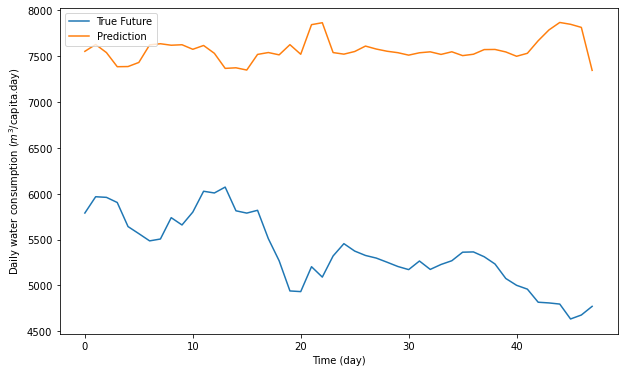

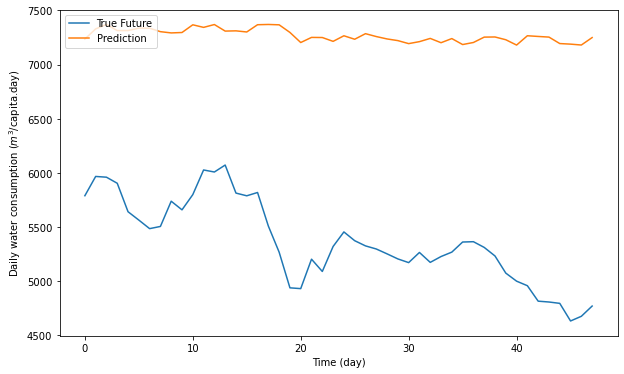

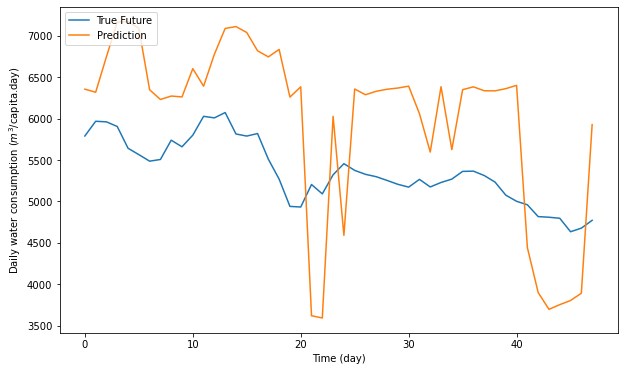

In [19]:
plot_future(prediction_bilstm, y_test)
plot_future(prediction_lstm, y_test)
plot_future(prediction_gru, y_test)

In [20]:
prediction_gru[-11:]

array([[6335.742 ],
       [6334.19  ],
       [6361.03  ],
       [6400.652 ],
       [4441.476 ],
       [3899.1216],
       [3696.3706],
       [3752.7275],
       [3802.9004],
       [3890.6748],
       [5927.033 ]], dtype=float32)

In [334]:
y_test[-11:]

array([[5814.535],
       [5763.275],
       [5792.12 ],
       [5812.19 ],
       [5843.14 ],
       [5874.835],
       [5871.05 ],
       [5858.66 ],
       [5839.545],
       [5850.065],
       [5884.78 ]])

In [335]:
prediction_bilstm[-11:]

array([[6193.855 ],
       [6186.811 ],
       [6124.047 ],
       [6071.7446],
       [6102.0938],
       [6121.8174],
       [6149.9634],
       [6175.915 ],
       [6172.9683],
       [6163.034 ],
       [6146.836 ]], dtype=float32)

In [336]:
rmse = sqrt(mean_squared_error(y_test[-11:-1], prediction_bilstm[-11:-1]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 318.815
